### Density Estimation 

- Following Manski et al.(2009)
- Three cases 
   - case 1. 3+ intervales with positive probabilities, to be fitted with a generalized beta distribution
   - case 2. exactly 2 adjacent intervals with positive probabilities, to be fitted with a triangle distribution 
   - case 3. __one or multiple__ intervals with equal probabilities, to be fitted with a uniform distribution
   

In [1]:
from scipy.stats import gamma
from scipy.stats import beta 
from scipy.stats import triang # new
from scipy.stats import uniform # new
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
import pandas as pd

In [2]:
# We need that for the 90-10 ratio:
def quantile(x,quantiles):
    xsorted = sorted(x)
    qvalues = [xsorted[int(q * len(xsorted))] for q in quantiles]
    return qvalues

### Case 1. Generalized Beta Distribution

In [3]:
def GeneralizedBetaEst(bin,probs):
    """
    This fits a histogram with positive probabilities in at least 3 bins to a generalized beta distribution.
    Depending on if there is open-ended bin on either side with positive probability, 
       the estimator decides to estimate 2 or 4 parameters, respectively. 
       
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
                 
    returns
    -------
    moments:  ndarray of 2 or 4  
              2:  alpha and beta 
              4:  alpha, beta, lb, ub, e.g. lb=0 and ub=1 for a standard beta distribution
    """
    # n+1 bins and n probs, both are arrays
    if sum([probs[i]>0 for i in range(len(bin)-1)])<3:
        print("Warning: at least three bins with positive probs are needed")
        para_est=[]
    if sum(probs)!=1:
        print("probs need to sum up to 1")
        para_est=[]
    else:
        cdf = np.cumsum(probs)
        pprob=[i for i in range(len(bin)-1) if probs[i]>0]
        lb=bin[min(pprob)]
        print("lower bound is "+str(lb))
        ub=bin[max(pprob)+1]
        print("upper bound is "+str(ub))
        
        x0_2para = (2,1)
        x0_4para = (2,1,0,1) 
        def distance2para(paras2): # if there is no open-ended bin with positive probs 
            a,b=paras2
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        def distance4para(paras4): # if either on the left or right side one open-ended bin is with postive probs
            a,b,lb,ub=paras4
            distance= sum((beta.cdf(bin[1:],a,b,loc=lb,scale=ub-lb)-cdf)**2)
            return distance
        if lb==bin[0] and ub==bin[-1]:
            para_est = minimize(distance4para,x0_4para,method='CG')['x'] 
        else:
            para_est = minimize(distance2para,x0_2para,method='CG')['x']
            scale = ub-lb
            para_est = np.concatenate([para_est,
                                      np.array([lb,scale])]
                                     )
        return para_est   # could be 2 or 4 parameters 

In [4]:
def GeneralizedBetaStats(a,b,lb,ub):
    """
    This function computes the moments of a generalized beta distribution, mean and variance for now. 
    
    parameters
    ----------
    a, b, lb, ub: floats #changed to a,b instead of alpha and beta
    
    returns
    -------
    dict:  2 keys
           mean, float 
           variance, float
           standard deviation, float
           ratio 90 10, float
    """
    # lb=0 and ub=1 for a standard beta distribution
    mean = lb + (ub-lb)*a/(a+b)
    var = (ub-lb)**2*a*b/((a+b)**2*(a+b+1))
    std = np.sqrt(var)
    # ratio
    x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 100)
    quantiles = quantile(x,[0.1, 0.9])
    iqr1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "iqr1090": iqr1090}

### Case 2. Isosceles Triangle distribution

Two adjacent intervales $[a,b]$,$[b,c]$ are assigned probs $\alpha$ and $1-\alpha$, respectively. In the case of $\alpha<1/2$, we need to solve parameter $t$ such that $[b-t,c]$ is the interval of the distribution. Denote the height of the trangle distribution $h$. Then following two restrictions need to satisfy

\begin{eqnarray}
\frac{t^2}{t+c-b} h = \alpha \\
(t+(c-b))h = 2
\end{eqnarray}

The two equations can solve $t$ and $h$

$$\frac{t^2}{(t+c-b)^2}=\alpha$$

$$t^2 = \alpha t^2 + 2\alpha t(c-b) + \alpha(c-b)^2$$

$$(1-\alpha) t^2 - 2\alpha(c-b) t - \alpha(c-b)^2=0$$

$$\implies t =\frac{2\alpha(c-b)+\sqrt{4\alpha^2(c-b)^2+4(1-\alpha)\alpha(c-b)^2}}{2(1-\alpha)} = \frac{\alpha(c-b)+(c-b)\sqrt{\alpha}}{(1-\alpha)}$$

$$\implies h = \frac{2}{t+c-b}$$

Rearrange to solve for c:
$$ \implies c = (t - b) - \frac{2}{h} $$
$$ \implies c = ub - \frac{2}{h} $$

In [5]:
def TriangleEst(bin,probs):
    """
    The function fits histograms with exactly two adjacent 
       bins with positive probabilitie to a triangular distribution.
    It genetes the bounds of the isoceles triangle distribution. 
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 3 keys
          lb: float, left bound 
          ub: float, right bound
          h:  float, height of the triangle
          c: float, mode
    
    """
    if sum([probs[i]>0 for i in range(len(bin)-1)])==2:
        print("There are two bins with positive probs")
        pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
        if sum(pprobadj)>0:
            print('The two intervals are adjacent and not open-ended')
            min_i = min(pprobadj)
            #print(min_i)
            #print(probs[min_i])
            #print(probs[min_i+1])
            #print(pprobadj[0])
            #print(pprobadj[0]+2)
            #print(probs[min_i] > probs[min_i+1])
            #print(bin[pprobadj[0]])
            #print(bin[pprobadj[0]+2])
            if probs[min_i] > probs[min_i+1]:
                alf = probs[min_i+1]
                lb = bin[pprobadj[0]]
                scl = bin[pprobadj[0]+1]-bin[pprobadj[0]]
                t = scl*(alf/(1-alf) +np.sqrt(alf)/(1-alf))
                ub = bin[pprobadj[0]+1]+t 
                h = 2/(t+bin[pprobadj[0]+1]-bin[pprobadj[0]])
                c = ub - 2/h
            if probs[min_i] < probs[min_i+1]:
                alf = probs[min_i]
                ub = bin[pprobadj[0]+2]
                scl = bin[pprobadj[0]+2]-bin[pprobadj[0]+1]
                t = scl*(alf/(1-alf) + np.sqrt(alf)/(1-alf))
                lb = bin[pprobadj[0]+1]-t  
                h = 2/(t+bin[pprobadj[0]+2]-bin[pprobadj[0]+1])
                c = ub - 2/h
            if probs[min_i] == probs[min_i+1]:
                ub=bin[pprobadj[0]]
                lb=bin[pprobadj[0]+2]
                h = 2/(ub-lb)
                c = ub - 2/h
        else:
            lb = []
            ub = []
            h = []
            c = []
            print('Warning: the two intervals are not adjacent or are open-ended')
    return {'lb':lb,'ub':ub,"height":h,"mode":c}

#### pdf of a triangle distribution

\begin{eqnarray}
f(x)= & 1/2(x-lb) \frac{x-lb}{(ub+lb)/2}h \quad \text{if } x <(lb+ub)/2 \\
& = 1/2(ub-x) \frac{ub-x}{(ub+lb)/2}h \quad \text{if } x \geq(lb+ub)/2
\end{eqnarray}

\begin{eqnarray}
& Var(x) & = \int^{ub}_{lb} (x-(lb+ub)/2)^2 f(x) dx \\
& & = 2 \int^{(ub+lb)/2}_{lb} (x-(lb+ub)/2)^2 (x-lb) \frac{x-lb}{(ub+lb)/2}h dx
\end{eqnarray}



In [6]:
def TriangleStats(lb,ub,c):
    """
    parameters
    ----------
    lb and ub:  float, left and right bounds of the triangle distribution
    c : float, mode
    
    returns
    -------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance
           std, float 
           irq1090, float  
    """
    
    mean = (lb+ub)/2
    var = (lb**2+ub**2+(lb+ub)**2/4-lb*(lb+ub)/2-ub*(lb+ub)/2-lb*ub)/18
    std = np.sqrt(var)
    x = np.linspace(triang.ppf(0.01, c, lb, ub), triang.ppf(0.99, c, lb, ub), 100)
    quantiles = quantile(x,[0.1, 0.9])
    iqr1090 = quantiles[0]/quantiles[1]
    return {"mean": mean,"variance":var, "std": std, "iqr1090": iqr1090}

### Case 3. Uniform Distribution

In [7]:
def UniformEst1bin(bin,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """
    pprob=[i for i in range(len(bin)-1) if probs[i]>0]
    if len(pprob)==1:
        if pprob[0]!=0 and pprob[0]!=len(bin)-1:
            lb = bin[pprob[0]]
            ub = bin[pprob[0]+1]
        else:
            lb=[]
            ub=[]
    else:
        lb=[]
        ub=[]
    return {"lb":lb,"ub":ub}

In [8]:
# New function: Takes into account that many bins have the same probability
def UniformEst(bins,probs):
    """
    This function fits a histogram with only one bin of positive probability to a uniform distribution.
    
    paramters
    ---------
    bins:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    --------
    dict: 2 keys
          lb and ub, float. the left and right bounds of the uniform distribution
    """    
    pos_bins = []
    # find non zero positions
    pos_entry = np.argwhere(probs!=0)
            
    for i in pos_entry:
        pos_bins.append(probs[i])
    pos_bins = np.hstack(pos_bins)   # clean    

    if len(pos_entry)>1:
        for i in range(len(pos_entry)-1) :
            if pos_entry[i+1] - pos_entry[i] !=1:
                pos_bins = [] 
               
    if len(pos_bins)==1:
        print('length pos bins is 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + 1]
        ub = ub[0] # into float
    if len(pos_bins)>1:
        print('length pos bins is > 1')
        lb = bins[pos_entry[0]]
        lb = lb[0] # into float
        ub = bins[pos_entry[0] + len(pos_bins)] 
        ub = ub[0] # into float
    if len(pos_bins)==0:
        lb=[]
        ub=[]

    return {"lb":lb,"ub":ub}

In [9]:
def UniformStats(lb,ub):
    """
    The function computes the moment of a uniform distribution.
    
    parameters
    ----------
    lb and ub, floats, left and right bounds of uniform distribution
    
    returns
    --------
    dict:  2 keys for now
           mean: estimated mean
           variance: estimated variance 
           std, float 
           irq1090, float  
    """
    
    if lb and ub: ## empty list is True
        mean = (lb+ub)/2
        var = (ub-lb)**2/12
        std = np.sqrt(var)
        x = np.linspace(uniform.ppf(lb),uniform.ppf(ub), 100)
        p10 = np.percentile(x, 10)
        p90 = np.percentile(x, 90)
        iqr1090 = p90/p10
    else:
        mean=[]
        var=[]
        std = []
        iqr1090 = []
    return {"mean": mean,"variance":var, "std": std, "iqr1090": iqr1090}

### Test using made-up data

In [10]:
## test 1: GenBeta Dist
sim_bins= np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs=np.array([0,0.2,0.5,0.3,0])
GeneralizedBetaEst(sim_bins,sim_probs)

lower bound is 0.2
upper bound is 1.0


array([2.08099415, 4.90193686, 0.2       , 0.8       ])

In [11]:
## test 2: Triangle Dist
sim_bins2 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs2=np.array([0,0.2,0.8,0,0])
TriangleEst(sim_bins2,sim_probs2)

There are two bins with positive probs
The two intervals are adjacent and not open-ended


{'lb': 0.1743769410125095,
 'ub': 0.5,
 'height': 6.142071161111579,
 'mode': 0.1743769410125095}

In [12]:
## test 3: Uniform Dist with one interval
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3 = np.array([0,0,1,0,0])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

length pos bins is 1
{'lb': 0.32, 'ub': 0.5}


{'mean': 0.41000000000000003,
 'variance': 0.0026999999999999997,
 'std': 0.05196152422706632,
 'iqr1090': 1.4260355029585798}

In [13]:
## test 4: Uniform Dist with multiple adjacent bins with same probabilities 
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0.2,0.2,0.2,0.2,0.2])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

length pos bins is > 1
{'lb': 0.0, 'ub': 1.2}


{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}

In [14]:
## test 5: Uniform Dist with multiple non-adjacent bins with equal probabilities
sim_bins3 = np.array([0,0.2,0.32,0.5,1,1.2])
sim_probs3=np.array([0,0.5,0,0.5,0])
para_est= UniformEst(sim_bins3,sim_probs3)
print(para_est)
UniformStats(para_est['lb'],para_est['ub']) 

{'lb': [], 'ub': []}


{'mean': [], 'variance': [], 'std': [], 'iqr1090': []}

### Test with simulated data from known distribution 
- we simulate data from a true beta distribution with known parameters
- then we estimate the parameters with our module and see how close it is with the true parameters 

lower bound is 0.044382792099258564
upper bound is 2.830488469670839
Estimated parameters [ 2.1739028   2.5351174  -0.32209774  2.98454291]
Estimated moments: {'mean': 1.204401418643676, 'variance': 0.4759808864147077, 'std': 0.6899136804084317, 'iqr1090': 0.1754085749895726}
True simulated moments: 1.2116453508405052 0.4630216806809759 0.680456964606121


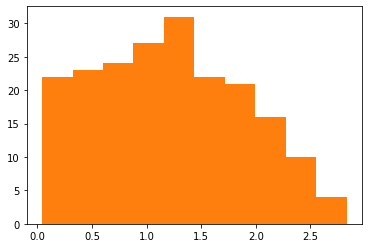

In [15]:
## simulate a generalized distribution
sim_n=200
true_alpha,true_beta,true_loc,true_scale=1.4,2.2,0,3
sim_data = beta.rvs(true_alpha,true_beta,
                    loc=true_loc,
                    scale=true_scale,
                    size=sim_n)
sim_bins2=plt.hist(sim_data)[1]
sim_probs2=plt.hist(sim_data)[0]/sim_n
sim_est=GeneralizedBetaEst(sim_bins2,sim_probs2)

print('Estimated parameters',sim_est)

print('Estimated moments:',GeneralizedBetaStats(sim_est[0],
                          sim_est[1],
                          sim_est[2],
                          sim_est[3]))

print('True simulated moments:',
      np.mean(sim_data),
     np.std(sim_data)**2,
     np.std(sim_data))

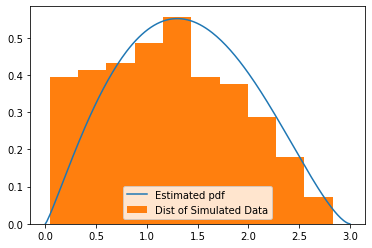

In [16]:
## plot the estimated generalized beta versus the histogram of simulated data drawn from a true beta distribution 
sim_x = np.linspace(true_loc,true_loc+true_scale,sim_n)
sim_pdf=beta.pdf(sim_x,sim_est[0],sim_est[1],loc=true_loc,scale=true_scale)
plt.plot(sim_x,sim_pdf,label='Estimated pdf')
plt.hist(sim_data,density=True,label='Dist of Simulated Data')
plt.legend(loc=0)

In [17]:
## This is the synthesized density estimation function
def SynDensityStat(bin,probs):
    """
    Synthesized density estimate module:
    It first detects the shape of histograms
    Then accordingly invoke the distribution-specific tool.
    
    paramters
    ---------
    bin:  ndarray, (n+1) x 1 
          positions for n bins in the histograms 
          
    probs:  ndarrray n x 1
          each entry is a probability for each of the n bins given by the surveyee, between 0 and 1
    
    returns
    -------
    moments: dict with 2 keys (more to be added in future)
            mean: empty or float, estimated mean 
            variance:  empty or float, estimated variance 
            std: empty or float, estimated standard deviation 
            irq1090: empty or float, estimated irq1090 
    
    """
    if sum(probs)==1:
        print("probs sum up to 1")
        ## Check if all bins have the same probability (special case for which we need Uniform and not Beta distributions)
        all_pos = 0
        pos_bin = []
        # find non zero positions
        pos_entry = np.argwhere(probs!=0)
            
        for i in pos_entry:
            pos_bin.append(probs[i])
        pos_bin = np.hstack(pos_bin)   # clean    

        if len(pos_entry)>1:
            for i in range(len(pos_entry)-1) :
                if pos_entry[i+1] - pos_entry[i] !=1:
                    pos_bin = [] 
                
        if len(pos_bin)!=0:
            if np.all(pos_bin == pos_bin[0]):
                all_pos = 1
                
                
        ## Beta distributions 
        if sum([probs[i]>0 for i in range(len(bin)-1)])>=3 and all_pos == 0:
            print("at least three bins with positive probs")
            para_est=GeneralizedBetaEst(bin,probs)
            if len(para_est)==4:
                print('4 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],para_est[2],para_est[3])
            if len(para_est)==2:
                print('2 parameters')
                return GeneralizedBetaStats(para_est[0],para_est[1],0,1)
        ## Triangle distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==2 and all_pos == 0:
            #print("There are two bins with positive probs")
            pprobadj = [i for i in range(1,len(bin)-3) if probs[i]>0 and probs[i+1]>0]   # from 1 to -3 bcz excluding the open-ended on the left/right
            if sum(pprobadj)>0:
                #print('The two intervals are adjacent and not open-ended')
                para_est=TriangleEst(bin,probs)
                return TriangleStats(para_est['lb'],para_est['ub'], para_est['mode'])
        ## Uniform distributions
        if sum([probs[i]>0 for i in range(len(bin)-1)])==1:
            print('Only one interval with positive probs')
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])
        if all_pos == 1:
            print("all bins have the same prob")
            para_est= UniformEst(bin,probs)
            print(para_est)
            return UniformStats(para_est['lb'],para_est['ub'])            
        else:
            return {"mean":[],"variance":[], "std":[], "irq1090":[]}
    else:
        return {"mean":[],"variance":[], "std":[], "irq1090":[]}

In [18]:
## testing the synthesized estimator function using an arbitrary example created above
SynDensityStat(sim_bins2,sim_probs2)['variance']
SynDensityStat(sim_bins2,sim_probs2)['iqr1090']

probs sum up to 1
at least three bins with positive probs
lower bound is 0.044382792099258564
upper bound is 2.830488469670839
4 parameters
probs sum up to 1
at least three bins with positive probs
lower bound is 0.044382792099258564
upper bound is 2.830488469670839
4 parameters


0.1754085749895726

In [19]:
### loading probabilistic data  
IndSPF=pd.read_stata('../data/sample_data.dta')   
# SPF inflation quarterly 
# 2 Inf measures: CPI and PCE
# 2 horizons: y-1 to y  and y to y+1

In [20]:
## survey-specific parameters 
nobs=len(IndSPF)
SPF_bins=np.array([-10,0,0.5,1,1.5,2,2.5,3,3.5,4,10])
print("There are "+str(len(SPF_bins)-1)+" bins in SPF")

There are 10 bins in SPF


In [21]:
len({'mean':1,'var':2})

2

In [22]:
##############################################
### attention: the estimation happens here!!!!!
###################################################

#IndSPF['PRCCPIMean0']='nan'   # CPI from y-1 to y 
#IndSPF['PRCCPIVar0']='nan'    
#IndSPF['PRCCPIMean1']='nan'  # CPI from y to y+1  
#IndSPF['PRCCPIVar1']='nan'
#IndSPF['PRCPCEMean0']='nan' # PCE from y-1 to y
#IndSPF['PRCPCEVar0']='nan'
#IndSPF['PRCPCEMean1']='nan' # PCE from y to y+1
#IndSPF['PRCPCEVar1']='nan'


## creating positions 
index  = IndSPF.index
columns=['PRCCPIMean0','PRCCPIVar0', 'PRCCPIStd0','PRCCPIIqr10900',
         'PRCCPIMean1','PRCCPIVar1','PRCCPIStd1','PRCCPIIqr10901',
         'PRCPCEMean0','PRCPCEVar0','PRCPCEStd0','PRCPCEIqr10900',
         'PRCPCEMean1','PRCPCEVar1','PRCPCEStd1','PRCPCEIqr10901']
IndSPF_moment_est = pd.DataFrame(index=index,columns=columns)

## Invoking the estimation

for i in range(nobs):
    print(i)
    ## take the probabilities (flip to the right order, normalized to 0-1)
    PRCCPI_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCCPI_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCCPI'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    PRCPCE_y0 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(1,11)]))
    print(PRCCPI_y0)
    PRCPCE_y1 = np.flip(np.array([IndSPF.iloc[i,:]['PRCPCE'+str(n)]/100 for n in range(11,21)]))
    print(PRCCPI_y1)
    if not np.isnan(PRCCPI_y0).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y0)
        if len(stats_est)>0:
            IndSPF_moment_est['PRCCPIMean0'][i]=stats_est['mean']
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIVar0'][i]=stats_est['variance']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIStd0'][i]=stats_est['std']
            print(stats_est['std'])
            IndSPF_moment_est['PRCCPIIqr10900'][i]=stats_est['iqr1090']
            print(stats_est['iqr1090'])            
    if not np.isnan(PRCCPI_y1).any():
        stats_est=SynDensityStat(SPF_bins,PRCCPI_y1)
        if len(stats_est):
            print(stats_est['mean'])
            IndSPF_moment_est['PRCCPIMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCCPIVar1'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCCPIStd1'][i]=stats_est['std']
            print(stats_est['iqr1090'])
            IndSPF_moment_est['PRCCPIIqr10901'][i]=stats_est['iqr1090']
    if not np.isnan(PRCPCE_y0).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y0)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean0'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar0'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCPCEStd0'][i]=stats_est['std']
            print(stats_est['iqr1090'])
            IndSPF_moment_est['PRCPCEIqr10900'][i]=stats_est['iqr1090']
    if not np.isnan(PRCPCE_y1).any():
        if len(stats_est)>0:
            stats_est=SynDensityStat(SPF_bins,PRCPCE_y1)
            print(stats_est)
            print(stats_est['mean'])
            IndSPF_moment_est['PRCPCEMean1'][i]=stats_est['mean']
            print(stats_est['variance'])
            IndSPF_moment_est['PRCPCEVar1'][i]=stats_est['variance']
            print(stats_est['std'])
            IndSPF_moment_est['PRCPCEStd1'][i]=stats_est['std']
            print(stats_est['iqr1090'])
            IndSPF_moment_est['PRCPCEIqr10900'][i]=stats_est['iqr1090']

0
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
[0.  0.  0.  0.  0.  0.4 0.4 0.2 0.  0. ]
[0.  0.  0.  0.  0.2 0.5 0.3 0.  0.  0. ]
probs sum up to 1
at least three bins with positive probs
lower bound is 2.0
upper bound is 3.5
4 parameters
1.7864800540885444
0.015267747488349866
0.12356272693798023
0.1285285506029574
probs sum up to 1
at least three bins with positive probs
lower bound is 1.5
upper bound is 3.0
4 parameters
1.5
0.0
0.0
0.19901505366719574
[]
[]
[]


KeyError: 'iqr1090'

In [ ]:
### exporting moments estimates to pkl
IndSPF_est = pd.concat([IndSPF,IndSPF_moment_est], join='inner', axis=1)
IndSPF_est.to_pickle("./DstSampleEst.pkl")
IndSPF_pk = pd.read_pickle('./DstSampleEst.pkl')

In [ ]:
IndSPF_pk['PRCCPIMean0']=pd.to_numeric(IndSPF_pk['PRCCPIMean0'],errors='coerce')   # CPI from y-1 to y 
IndSPF_pk['PRCCPIVar0']=pd.to_numeric(IndSPF_pk['PRCCPIVar0'],errors='coerce')  
IndSPF_pk['PRCCPIStd0']=pd.to_numeric(IndSPF_pk['PRCCPIStd0'],errors='coerce') 
IndSPF_pk['PRCCPIIqr10900']=pd.to_numeric(IndSPF_pk['PRCCPIIqr10900'],errors='coerce') 

IndSPF_pk['PRCCPIMean1']=pd.to_numeric(IndSPF_pk['PRCCPIMean1'],errors='coerce')   # CPI from y to y+1  
IndSPF_pk['PRCCPIVar1']=pd.to_numeric(IndSPF_pk['PRCCPIVar1'],errors='coerce')
IndSPF_pk['PRCCPIStd1']=pd.to_numeric(IndSPF_pk['PRCCPIStd1'],errors='coerce')
IndSPF_pk['PRCCPIIqr10901']=pd.to_numeric(IndSPF_pk['PRCCPIIqr10901'],errors='coerce')

IndSPF_pk['PRCPCEMean0']=pd.to_numeric(IndSPF_pk['PRCPCEMean0'],errors='coerce')  # PCE from y-1 to y
IndSPF_pk['PRCPCEVar0']=pd.to_numeric(IndSPF_pk['PRCPCEVar0'],errors='coerce') 
IndSPF_pk['PRCPCEStd0']=pd.to_numeric(IndSPF_pk['PRCPCEStd0'],errors='coerce') 
IndSPF_pk['PRCPCEIqr10900']=pd.to_numeric(IndSPF_pk['PRCPCEIqr10900'],errors='coerce') 

IndSPF_pk['PRCPCEMean1']=pd.to_numeric(IndSPF_pk['PRCPCEMean1'],errors='coerce')  # PCE from y to y+1
IndSPF_pk['PRCPCEVar1']=pd.to_numeric(IndSPF_pk['PRCPCEVar1'],errors='coerce')
IndSPF_pk['PRCPCEStd1']=pd.to_numeric(IndSPF_pk['PRCPCEStd1'],errors='coerce')
IndSPF_pk['PRCPCEIqr10901']=pd.to_numeric(IndSPF_pk['PRCPCEIqr10901'],errors='coerce')

In [ ]:
IndSPF_pk.tail()

In [ ]:
IndSPF_pk.to_stata('../data/Dstsample_data.dta')

In [ ]:
### Robustness checks: focus on big negative mean estimates 
sim_bins_data = SPF_bins
print(str(sum(IndSPF_pk['PRCCPIMean1']<-2))+' abnormals')
ct=0
figure=plt.plot()
for id in IndSPF_pk.index[IndSPF_pk['PRCCPIMean1']<-2]:
    print(id)
    print(IndSPF_pk['PRCCPIMean1'][id])
    sim_probs_data= np.flip(np.array([IndSPF['PRCCPI'+str(n)][id]/100 for n in range(11,21)]))
    plt.bar(sim_bins_data[1:],sim_probs_data)
    print(sim_probs_data)
    stats_est=SynDensityStat(SPF_bins,sim_probs_data)
    print(stats_est['mean'])